In [4]:
import os, sys
import shutil
import glob
import json
import face_recognition

import numpy as np
import pandas as pd

from PIL import Image

from tqdm import tqdm_notebook
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from bing_image_downloader.downloader import download

RANDOM = 42

# 1 Импорт данных

In [7]:
with open('../config/actress_actors.json', 'r') as fp:
    dict_act = json.load(fp)
    
SIZE = 256

In [126]:
# get actresses only
for key in list(dict_act.keys())[:1]:
    # loop each name
    for face in dict_act[key]:
        str_face = f'face {face}'
        dir_ = f'dataset/{key}'
        
        # download 15 photo current name
        download(str_face,
                 limit=15,
                 output_dir=dir_,
                 adult_filter_off=True,
                 force_replace=False,
                 timeout=60,
                 verbose=True)
        
        # change name of dir
        os.rename(f'dataset/{key}/' + str_face, f'dataset/{key}/' + face)


[%] Downloading Images to /Users/maksimfomin/Desktop/IT/Learn/DS_practice/4. CV/1. Deepfake. Data Science проект поиска похожих актеров/dataset/women/face Amy Adams


[!!]Indexing page: 1
[%] Indexed 15 Images on Page 1.


[%] Downloading Image #1 from http://media1.popsugar-assets.com/files/thumbor/4tRrGT1zHMwzIq_APg3lCYnwEPs=/fit-in/2048xorig/2015/01/11/030/n/1922153/6166416ee1406c5b_461354614/i/Amy-Adams.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://i.pinimg.com/736x/81/4b/e8/814be8a408e4c6f840dc5fd71d848a56.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://media.glamour.com/photos/570433d1c08406e85210548f/master/pass/inspired-2016-03-amy-adams-1-main.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://images.wallpapersden.com/image/download/amy-adams-actress-face_aGZmbWiUmZqaraWkpJRuamWtZmpoaQ.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://www.hawtcelebs.com/wp-content/uploads/2014/01/amy-adams-at-71st-annual-golden-g

# Форматирование размера изображений

In [127]:
# get actresses only
for key in list(dict_act.keys())[:1]:
    # loop each name
    for face in dict_act[key]:
        # download all file names from folder
        files = glob.glob(f'dataset/{key}/{face}/*')
        # loop list
        for i in files:
            try:
                # open image
                image = Image.open(i)
                # get image size
                size = image.size
                
                # get coeff for resize
                coef = SIZE / size[0]
                
                # resize image
                resized_image = image.resize(
                    (int(size[0] * coef), int(size[1] * coef)))
                resized_image = resized_image.convert('RGB')\
                
                # save
                resized_image.save(i)
            except:
                os.remove(i)


In [128]:
!ls 'dataset/women/Angelina Jolie'

Image_1.jpg  Image_11.jpg Image_2.jpg  Image_4.jpg  Image_6.jpg  Image_8.jpg
Image_10.jpg Image_12.jpg Image_3.jpg  Image_5.jpg  Image_7.jpg  Image_9.jpg


In [129]:
# get image from file
image = face_recognition.load_image_file("./dataset/women/Angelina Jolie/Image_1.jpg")

# get coordinates of face
# return (top, right, bottom, left)
face_locations = face_recognition.face_locations(image)

In [130]:
# coordinates start
xy = (face_locations[0][3], face_locations[0][0])

# get width and height
width = face_locations[0][1] - face_locations[0][3]
height = face_locations[0][2] - face_locations[0][0]

In [131]:
face_locations

[(142, 256, 365, 43)]

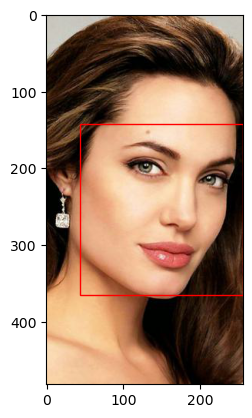

In [132]:
plt.imshow(image)

# get current link
ax = plt.gca()

# add rectangle with face
rect = patches.Rectangle(xy, width, height, linewidth=1, edgecolor='r', facecolor='None')
ax.add_patch(rect)

In [133]:
with open('config/actress_actors.json', 'r') as fp:
    dict_act = json.load(fp)

In [134]:
# get images count
dict_labels = dict()
for i, key in enumerate(dict_act['women']):
    dict_labels[key] = i

dict_labels

{'Amy Adams': 0,
 'Andie MacDwell': 1,
 'Angelina Jolie': 2,
 'Anna Hathaway': 3,
 'Cameron Diaz': 4,
 'Carey Mulligan': 5,
 'Kira Nightly': 6,
 'Jennifer Anniston': 7,
 'Margo Robbi': 8,
 'Emma Watson': 9,
 'Ann Hatwey': 10,
 'Charlies Theron': 11,
 'Julia Roberts': 12,
 'Megan Fox': 13,
 'Christen Stewart': 14,
 'Scarlett Johanson': 15,
 'Kate Winslett': 16,
 'Sharon Stone': 17,
 'Penelopa Cruz': 18,
 'Sandra Bullock': 19,
 'Jennifer Lawrence': 20,
 'Emilia Clark': 21,
 'Julianna Moore': 22,
 'Elizabeth Harley': 23,
 'Rachel McAdams': 24,
 'Jennifer Love-Hewett': 25,
 'Kate Hudson': 26,
 'Jessica Chasten': 27,
 'Elizabeth Banks': 28,
 'Kate Blanche': 29,
 'Uma Thurman': 30,
 'Wynona Ryder': 31,
 'Jody Foster': 32,
 'Diana Kruger': 33,
 'Meg Ryan': 34}

In [135]:
len(dict_labels)

35

In [136]:
embeddings = np.empty(128)
target = []

key = 'women'

for person in tqdm_notebook(list(dict_labels.keys())):
    files = len(glob.glob(f'dataset/women/{person}/*'))
    if files < 2:
        print(f'Убираем из датасета: {person}')
        shutil.rmtree(f'dataset/women/{person}')
        #TODO add deleting of person
    else:
        # get list of images in folder
        images = os.listdir(f"./dataset/{key}/{person}")
        len_images = len(images)
        
        for num, person_img in enumerate(images):
            try:
                if person_img != '.DS_Store':
                    # read image
                    face = face_recognition.load_image_file(
                        f"dataset/{key}/{person}/{person_img}")
                    # get face coordinates
                    face_bounding_boxes = face_recognition.face_locations(face)
                    
                    # If face_count = 0 or face_count > 1 then skip
                    if len(face_bounding_boxes) == 1:
                        try:
                            # transform photo wit face to vector, get embedding
                            face_enc = face_recognition.face_encodings(face)[0]
                            
                            # add matrix to dataset
                            embeddings = np.vstack((embeddings, face_enc))
                            
                            # add target to current index
                            target.append(dict_labels[person])
                            
                        except Exception as ex:
                            print(f'Error message {ex}')
            except Exception as ex:
                print(f'Error message {ex}')


/var/folders/65/m0n5yb356zg5yw45tc1gq3m00000gn/T/ipykernel_19475/2328609648.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for person in tqdm_notebook(list(dict_labels.keys())):


  0%|          | 0/35 [00:00<?, ?it/s]

Убираем из датасета: Andie MacDwell
Убираем из датасета: Emma Watson
Убираем из датасета: Charlies Theron
Убираем из датасета: Scarlett Johanson
Убираем из датасета: Kate Winslett
Убираем из датасета: Sharon Stone
Убираем из датасета: Sandra Bullock
Убираем из датасета: Elizabeth Harley
Убираем из датасета: Elizabeth Banks
Убираем из датасета: Kate Blanche
Убираем из датасета: Jody Foster


In [137]:
list_of_actresses = next(os.walk('./dataset/women'))[1]

keys_to_remove = []
for i in list(dict_labels.keys()):
    if i not in list_of_actresses:
        keys_to_remove.append(i)

for k in keys_to_remove:
    dict_labels.pop(k)

In [138]:
dict_labels

{'Amy Adams': 0,
 'Angelina Jolie': 2,
 'Anna Hathaway': 3,
 'Cameron Diaz': 4,
 'Carey Mulligan': 5,
 'Kira Nightly': 6,
 'Jennifer Anniston': 7,
 'Margo Robbi': 8,
 'Ann Hatwey': 10,
 'Julia Roberts': 12,
 'Megan Fox': 13,
 'Christen Stewart': 14,
 'Penelopa Cruz': 18,
 'Jennifer Lawrence': 20,
 'Emilia Clark': 21,
 'Julianna Moore': 22,
 'Rachel McAdams': 24,
 'Jennifer Love-Hewett': 25,
 'Kate Hudson': 26,
 'Jessica Chasten': 27,
 'Uma Thurman': 30,
 'Wynona Ryder': 31,
 'Diana Kruger': 33,
 'Meg Ryan': 34}

In [139]:
len(dict_labels)

24

In [140]:
len(list_of_actresses)

24

In [141]:
# Delete first element from dataset, cause this is empty matrix
embeddings_ = embeddings[1:]

In [142]:
embeddings_.shape

(340, 128)

In [143]:
len(target)

340

In [144]:
embeddings_[0]

array([-8.65517110e-02,  2.42127255e-02,  1.82338208e-02, -9.79000777e-02,
       -1.47835881e-01,  3.89944911e-02, -5.67584038e-02, -1.22172490e-01,
        1.98310941e-01, -6.02212250e-02,  1.46381497e-01, -1.48011036e-02,
       -2.36657858e-01, -6.25155866e-04,  7.71830827e-02,  1.49920613e-01,
       -1.95741564e-01, -1.51279092e-01, -5.54954633e-02, -7.40720928e-02,
       -5.37696667e-02,  4.81747538e-02,  4.74401154e-02,  1.45675853e-01,
       -1.48858130e-01, -2.92834818e-01, -1.28197238e-01, -4.64906879e-02,
       -2.31819898e-02, -6.54251724e-02,  5.52903526e-02,  5.10751233e-02,
       -1.72883719e-01, -1.67608261e-04,  5.63955158e-02,  1.41322255e-01,
       -1.06925659e-01, -2.27933109e-01,  2.13102400e-01,  2.44588815e-02,
       -1.64868236e-01, -9.16177928e-02,  1.20725513e-01,  2.18689263e-01,
        3.04006994e-01, -3.53819355e-02,  1.00924410e-02, -4.40809131e-02,
        1.74958974e-01, -3.09392899e-01,  1.11791342e-01,  1.42449677e-01,
        3.39622283e-03,  

In [ ]:
with open('static/embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings_, f)

with open('static/labels.pkl', 'wb') as f:
    pickle.dump(target, f)

In [ ]:
with open('static/embeddings.pkl', 'wb') as f:
    pickle.load(f)

with open('static/labels.pkl', 'wb') as f:
    pickle.load(f)

# Обучение модели

In [145]:
X_train, X_test, y_train, y_test = train_test_split(
    embeddings_, target, test_size=0.3, stratify=target, random_state=RANDOM)

In [146]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [147]:
y_predict = model.predict(X_test)
f1 = f1_score(y_test, y_predict, average='micro')

print(f'F1 score = {f1}')

F1 score = 0.9509803921568627


# Тестирование на реальном фото

In [148]:
def resize_image(SIZE, image):
    # get size
    size = image.size
    
    # get coeff for resize
    coef = SIZE / size[0]

    # resize image
    resized_image = image.resize(
        (int(size[0] * coef), int(size[1] * coef)))
    res_image = resized_image.convert('RGB')
    
    return res_image

In [149]:
SIZE = 1024

image = Image.open('img_test/my_test.jpg')
res_image = resize_image(SIZE, image)
res_image.save('img_test/my_test_res.jpg')

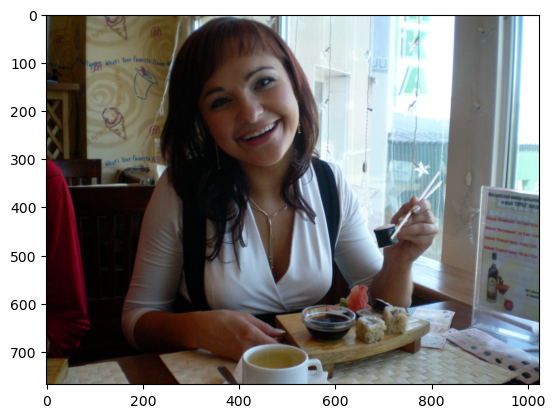

In [150]:
plt.imshow(res_image)

In [165]:
def predict_actress(path, model, dict_labels):
    face = face_recognition.load_image_file(path)
    face_bounding_boxes = face_recognition.face_locations(face)
    
    if len(face_bounding_boxes) != 1:
        print('Problem with finding a face')
    else:
        # transform photo wit face to vector, get embedding
        face_enc = face_recognition.face_encodings(face)[0]

        # predict actress/actor
        predict = model.predict([face_enc])
        predict_labels = list(dict_labels.keys())[list(dict_labels.values()).index(predict)]
        
        predict_proba = model.predict_proba([face_enc])
        
        return predict_labels, predict_proba

In [166]:
predict_name, predict_proba = predict_actress('img_test/my_test_res.jpg', model, dict_labels)
predict_name

'Kate Hudson'

In [167]:
predict_proba

array([[0.01598914, 0.042783  , 0.03584147, 0.0540647 , 0.03943468,
        0.03786642, 0.0297527 , 0.03103938, 0.0371713 , 0.03416231,
        0.04127965, 0.04650197, 0.06033679, 0.04402928, 0.05411962,
        0.03265663, 0.05630012, 0.04823875, 0.06190861, 0.03175573,
        0.02901456, 0.06125213, 0.02488313, 0.04961792]])

In [168]:
# table with scores
df = pd.DataFrame()

df['act'] = list(dict_labels.keys())
df['score'] = predict_proba[0]
df

,act,score
0,Amy Adams,0.015989
1,Angelina Jolie,0.042783
2,Anna Hathaway,0.035841
3,Cameron Diaz,0.054065
4,Carey Mulligan,0.039435
5,Kira Nightly,0.037866
6,Jennifer Anniston,0.029753
7,Margo Robbi,0.031039
8,Ann Hatwey,0.037171
9,Julia Roberts,0.034162


In [169]:
df.sort_values(by='score')[::-1]

,act,score
18,Kate Hudson,0.061909
21,Wynona Ryder,0.061252
12,Penelopa Cruz,0.060337
16,Rachel McAdams,0.056300
14,Emilia Clark,0.054120
3,Cameron Diaz,0.054065
23,Meg Ryan,0.049618
17,Jennifer Love-Hewett,0.048239
11,Christen Stewart,0.046502
13,Jennifer Lawrence,0.044029


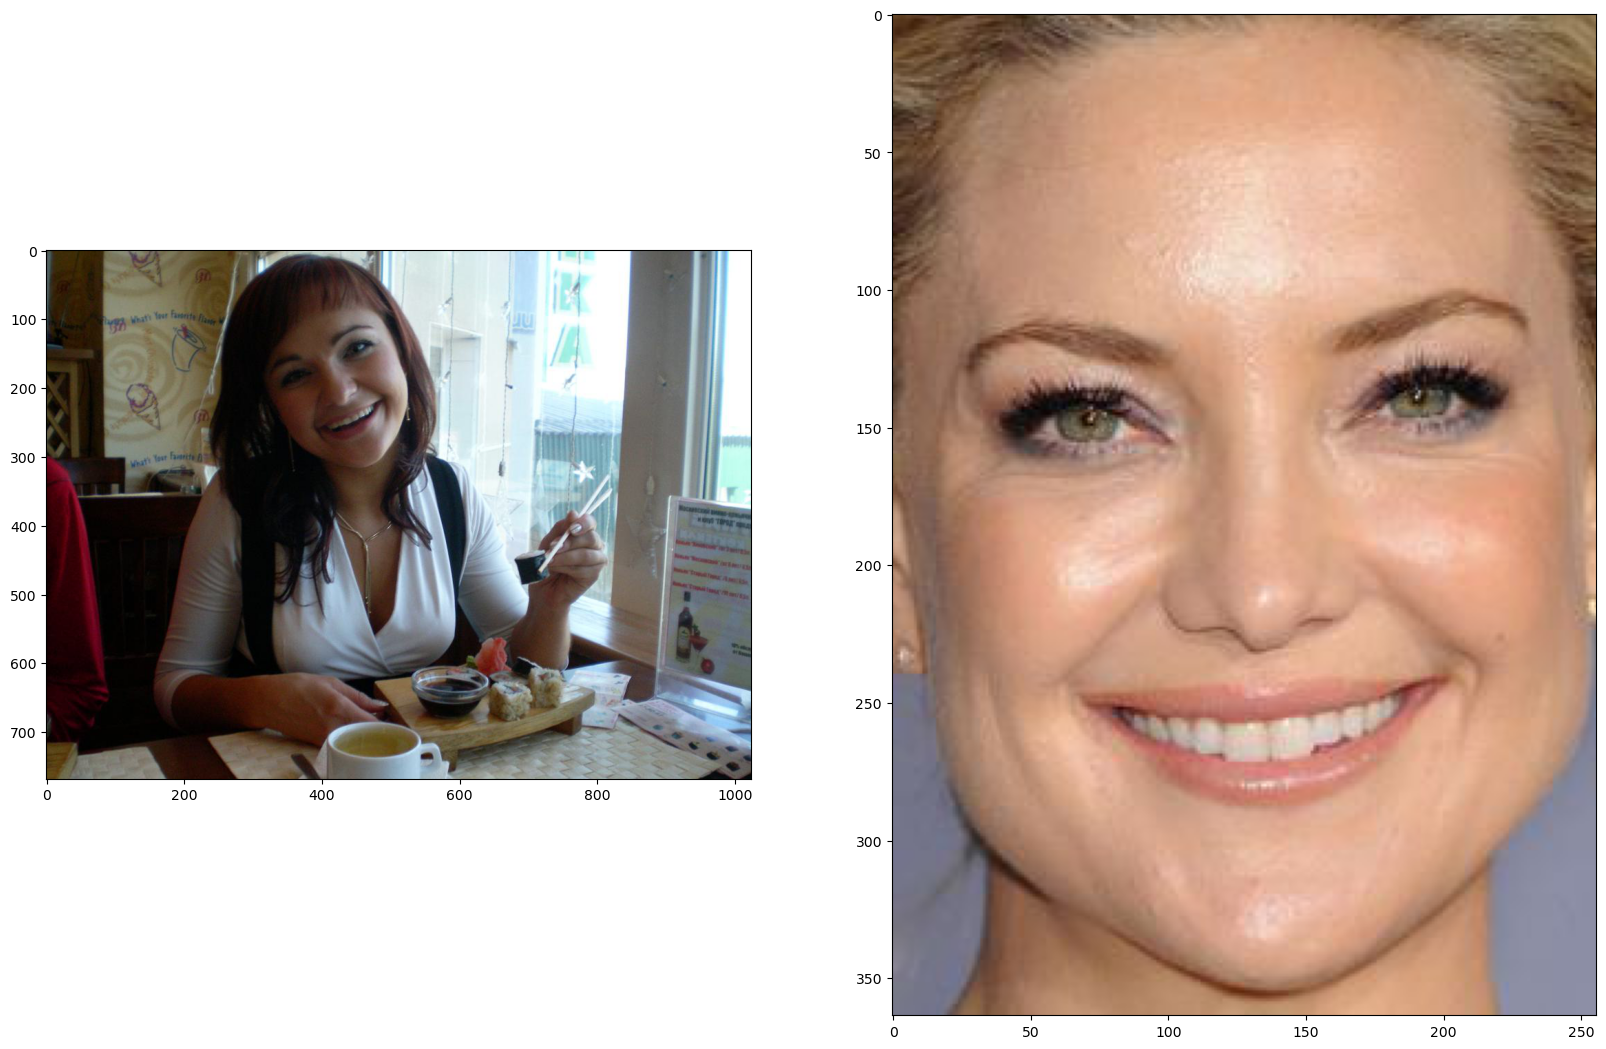

In [170]:
num_image = 11

image1 = face_recognition.load_image_file("img_test/my_test_res.jpg")
image2 = face_recognition.load_image_file(f"dataset/women/{predict_name}/Image_{num_image}.jpg")

fig, ax = plt.subplots(1, 2, figsize=(20,20))

ax[0].imshow(image1)
ax[1].imshow(image2);

# Получение средней оценики cosine

In [171]:
def comparasion(path_test, name_act, num_image):
    # face as a test
    face_1 = face_recognition.load_image_file(path_test)
    face_enc_1 = face_recognition.face_encodings(face_1)[0]
    
    # actress
    path_act = f"dataset/women/{name_act}/Image_{num_image}.jpg"
    
    face_2 = face_recognition.load_image_file(path_act)
    face_enc_2 = face_recognition.face_encodings(face_2)[0]
    
    return cosine_similarity(face_enc_1.reshape(1, -1), face_enc_2.reshape(1, -1))[0]

In [172]:
len_files = len(glob.glob(f'dataset/women/{predict_name}/*'))
cos = []

for i in tqdm_notebook(range(len_files)):
    try:
        cos_ = comparasion('img_test/my_test_res.jpg', predict_name, i)
        cos.append(cos_)
        print(i, cos_)
    except Exception as ex:
        print(f'message: {ex}')
print(f'Mean score = {np.mean(cos)}')

/var/folders/65/m0n5yb356zg5yw45tc1gq3m00000gn/T/ipykernel_19475/4238191103.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len_files)):


  0%|          | 0/14 [00:00<?, ?it/s]

message: [Errno 2] No such file or directory: 'dataset/women/Kate Hudson/Image_0.jpg'
1 [0.88238908]
2 [0.9024864]
3 [0.88199982]
4 [0.90117543]
5 [0.89551025]
6 [0.89960512]
7 [0.91096342]
8 [0.91428548]
9 [0.89085185]
10 [0.89394298]
11 [0.9064281]
12 [0.8992503]
13 [0.89083935]
Mean score = 0.8976713526723292


In [ ]:
#TODO:
# - implement:
#       - Airflow
#       - Streamlit
#